# Short Photoreceptor Diversity 
Explore differences in the connectivity of short photoreceptor (R1-6) subtypes

In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

#import sys
from cx_analysis.dataframe_tools import extract_connector_table
from cx_analysis.cartridge_metadata import ret_clusters
from cx_analysis.vis.fig_tools import subtype_cm
from cx_analysis.vis.hex_lattice import hexplot

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

In [24]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module

save_figs = False
if save_figs:
    fig_path = os.path.expanduser('~/Figures/')

In [5]:
# synaptic links (contacts)
tp = '210809'
data_path = f'Data/210809_linkdf.pickle'
df = pd.read_pickle(data_path)

# Rhabdom vols from Anastasia
rb = pd.read_csv('Data/cell_rbd_volume.xlsx').set_index('rtype').T
rb.index.name = 'om'
rb = rb.loc[sorted(rb.index), sorted(rb.columns)]
rb_frac = (rb.T/rb.sum(axis=1)).T.rename(mapper={'vol': 'fvol'}, axis=1)

rtypes = rb.columns
subtypes = np.unique(df['post_type'])
ommatidia = np.unique(df['pre_om'])

ret_clust = ret_clusters()

cm = subtype_cm()

ct_df = extract_connector_table(df) # DataFrame of connectors (presyn terminals)

In [6]:
# We are interested in both the number of contacts and the number of terminals 
n_terminals = {om: dict.fromkeys(rtypes) for om in ommatidia}
n_contacts = {om: dict.fromkeys(rtypes) for om in ommatidia}
n_outs = df['pre_neuron'].value_counts().to_dict() # count of links associated with every neuron

# Filter out non-short PR contacts/terminals
# TODO: helper function to add column for sub sub type (e.g. 'R1' instead of R1R4)
# This can be done from link_df, TODO: MAKE MORE GENERAL AND PUT IN DATAFRAME TOOLS
for pre_name, these_rows in ct_df.groupby('pre_neuron'):
    # using our neuron name pattern to get ommatidium/rtypes of indv photoreceptors
    if pre_name[0:2] == 'om' and pre_name[5] == 'R':  
        om = pre_name[2: 4]
        r = pre_name.split('_')[1]
        assert(len(r) in (2, 3))
        n_terminals[om][r] = len(these_rows)
        n_contacts[om][r] = n_outs.get(pre_name, 0)
    else:
        continue

terms = pd.DataFrame(n_terminals).fillna(0).astype(int).T
ctx = pd.DataFrame(n_contacts).fillna(0).astype(int).T

terms.index.name = 'om'
ctx.index.name = 'om'

In [7]:
# fig, axes = plt.subplots(3, 3, figsize=[9, 9])

# for i, ax in enumerate(axes.flatten()):
#     hexplot(terms.iloc[:, i], ax=ax)

In [8]:
# fig, axes = plt.subplots(3, 3, figsize=[9, 9])

# for i, ax in enumerate(axes.flatten()):
#     hexplot_TEST(terms.iloc[:, i], ax=ax, var_lim=[0, terms.iloc[:, i].max()])

In [9]:
# Longform dataframes for seaborn functions
# Alternatives: number of contacts or number of pre terminals, rhabdomere vol or faction of rhabdom total
# Decide which is concatenated in combined

l_terms = pd.melt(terms.reset_index(), id_vars='om', value_vars=terms.columns, var_name='subtype', value_name='term_count')
l_rbfrac = pd.melt(rb_frac.reset_index(), id_vars='om', value_vars=rb_frac.columns,  var_name='subtype', value_name='fvol')
l_ctx = pd.melt(ctx.reset_index(), id_vars='om', value_vars=ctx.columns, var_name='subtype', value_name='syn_count')
l_rb = pd.melt(rb.reset_index(), id_vars='om', value_vars=rb.columns,  var_name='subtype', value_name='vol')

# combined has fields for 'vol': raw volume, 'fvol': fractional volume, 'syn_count': connection count, 'term_count': terminal count 
combined = pd.concat([l_rb, l_rbfrac['fvol'], l_ctx['syn_count'], l_terms['term_count']], axis=1)


In [10]:
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]
multi = (data['syn_count']/data['term_count']).mean()
multi_sd = (data['syn_count']/data['term_count']).std(ddof=0)

display(len(data))
display(multi)
display(multi_sd)

174

8.080337219688133

1.1929343242548973

## Differences between pairs of opposite short photoreceptor

In [27]:
q_ind = [i for i, s in combined['subtype'].iteritems() if s in ('R1', 'R4', 'R3', 'R6')]
d_ind = [i for i, s in combined['subtype'].iteritems() if s in ('R2', 'R5')]
# Rhabdomere volume
quart = combined.loc[q_ind, 'vol']
duet = combined.loc[d_ind, 'vol']

U, p = mannwhitneyu(quart, duet, alternative='less')
print("###### Rhabdomere volume ######")
print(f"Quartet: {quart.mean(): .1f} +- {quart.std(ddof=0): .1f} (n={len(quart)})")
print(f"Duet: {duet.mean(): .1f} +- {duet.std(ddof=0): .1f} (n={len(duet)})")
print(f"Test statistic, U = {U}, p-value = {p: .2e}")
if p > 0.001:
    print("Fail to reject null")
else:
    print("Reject null: Quartet cells have smaller rhabdomere volumes than duet cells")
print("\n")
# Fraction of rhabdom volume
quart = combined.loc[q_ind, 'fvol']
duet = combined.loc[d_ind, 'fvol']

U, p = mannwhitneyu(quart, duet, alternative='less')
print("###### Fraction of rhabdom volume ######")
print(f"Quartet: {quart.mean(): .02f} +- {quart.std(ddof=0): .03f} (n={len(quart)})")
print(f"Duet: {duet.mean(): .02f} +- {duet.std(ddof=0): .03f} (n={len(duet)})")
print(f"Test statistic, U = {U}, p-value = {p: .2e}")
if p > 0.001:
    print("Fail to reject null")
else:
    print("Reject null: Quartet cells occupy a smaller fraction of the rhabdom than duet cells")
print("\n")
# Synaptic contacts
quart = combined.loc[q_ind, 'syn_count']
duet = combined.loc[d_ind, 'syn_count']

U, p = mannwhitneyu(quart, duet, alternative='less')
print("###### Synaptic outputs ######")
print(f"Quartet: {quart.mean(): .0f} +- {quart.std(ddof=0): .0f} (n={len(quart)})")
print(f"Duet: {duet.mean(): .0f} +- {duet.std(ddof=0): .0f} (n={len(duet)})")
print(f"Test statistic, U = {U}, p-value = {p: .2e}")
if p > 0.001:
    print("Fail to reject null")
else:
    print("Reject null: Quartet cells have fewer synaptic outputs than duet cells")
print("\n")
# Synaptic contacts
quart = combined.loc[q_ind, 'term_count']
duet = combined.loc[d_ind, 'term_count']

U, p = mannwhitneyu(quart, duet, alternative='less')
print("###### Preynaptic terminals ######")
print(f"Quartet: {quart.mean(): .0f} +- {quart.std(ddof=0): .0f} (n={len(quart)})")
print(f"Duet: {duet.mean(): .0f} +- {duet.std(ddof=0): .0f} (n={len(duet)})")
print(f"Test statistic, U = {U}, p-value = {p: .2e}")
if p > 0.001:
    print("Fail to reject null")
else:
    print("Reject null: Quartet cells have fewer presynaptic terminals than duet cells")    

###### Rhabdomere volume ######
Quartet:  3.0 +-  1.3 (n=116)
Duet:  4.9 +-  1.6 (n=58)
Test statistic, U = 1214.0, p-value =  3.39e-12
Reject null: Quartet cells have smaller rhabdomere volumes than duet cells


###### Fraction of rhabdom volume ######
Quartet:  0.07 +-  0.019 (n=116)
Duet:  0.12 +-  0.021 (n=58)
Test statistic, U = 341.0, p-value =  2.48e-22
Reject null: Quartet cells occupy a smaller fraction of the rhabdom than duet cells


###### Synaptic outputs ######
Quartet:  70 +-  16 (n=116)
Duet:  104 +-  12 (n=58)
Test statistic, U = 372.0, p-value =  6.35e-22
Reject null: Quartet cells have fewer synaptic outputs than duet cells


###### Preynaptic terminals ######
Quartet:  9 +-  2 (n=116)
Duet:  13 +-  2 (n=58)
Test statistic, U = 290.5, p-value =  2.23e-23
Reject null: Quartet cells have fewer presynaptic terminals than duet cells


### **Fraction of rhabdom volume** vs **number of synaptic outputs**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              syn_count   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     78.86
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           8.58e-16
Time:                        14:05:22   Log-Likelihood:                -751.03
No. Observations:                 174   AIC:                             1506.
Df Residuals:                     172   BIC:                             1512.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.1909      3.286     16.795      0.000      48.705      61.677
vol            7.3647      0.829      8.881      0.000       5.728       9.002
==============================================================================
Omnibus:                        0.097   Durbin-Watson:                   1.334
Prob(Omnibus):                  0.952   Jarque-Bera (JB):                0.154
Skew:                           0.056   Prob(JB):                        0.926
Kurtosis:                       2.906   Cond. No.                         9.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/nchua/miniconda3/envs/wasp/lib/python3.8/site-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/Users/nchua/miniconda3/envs/wasp/lib/python3.8/site-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


const    55.190874
vol       7.364721
dtype: float64

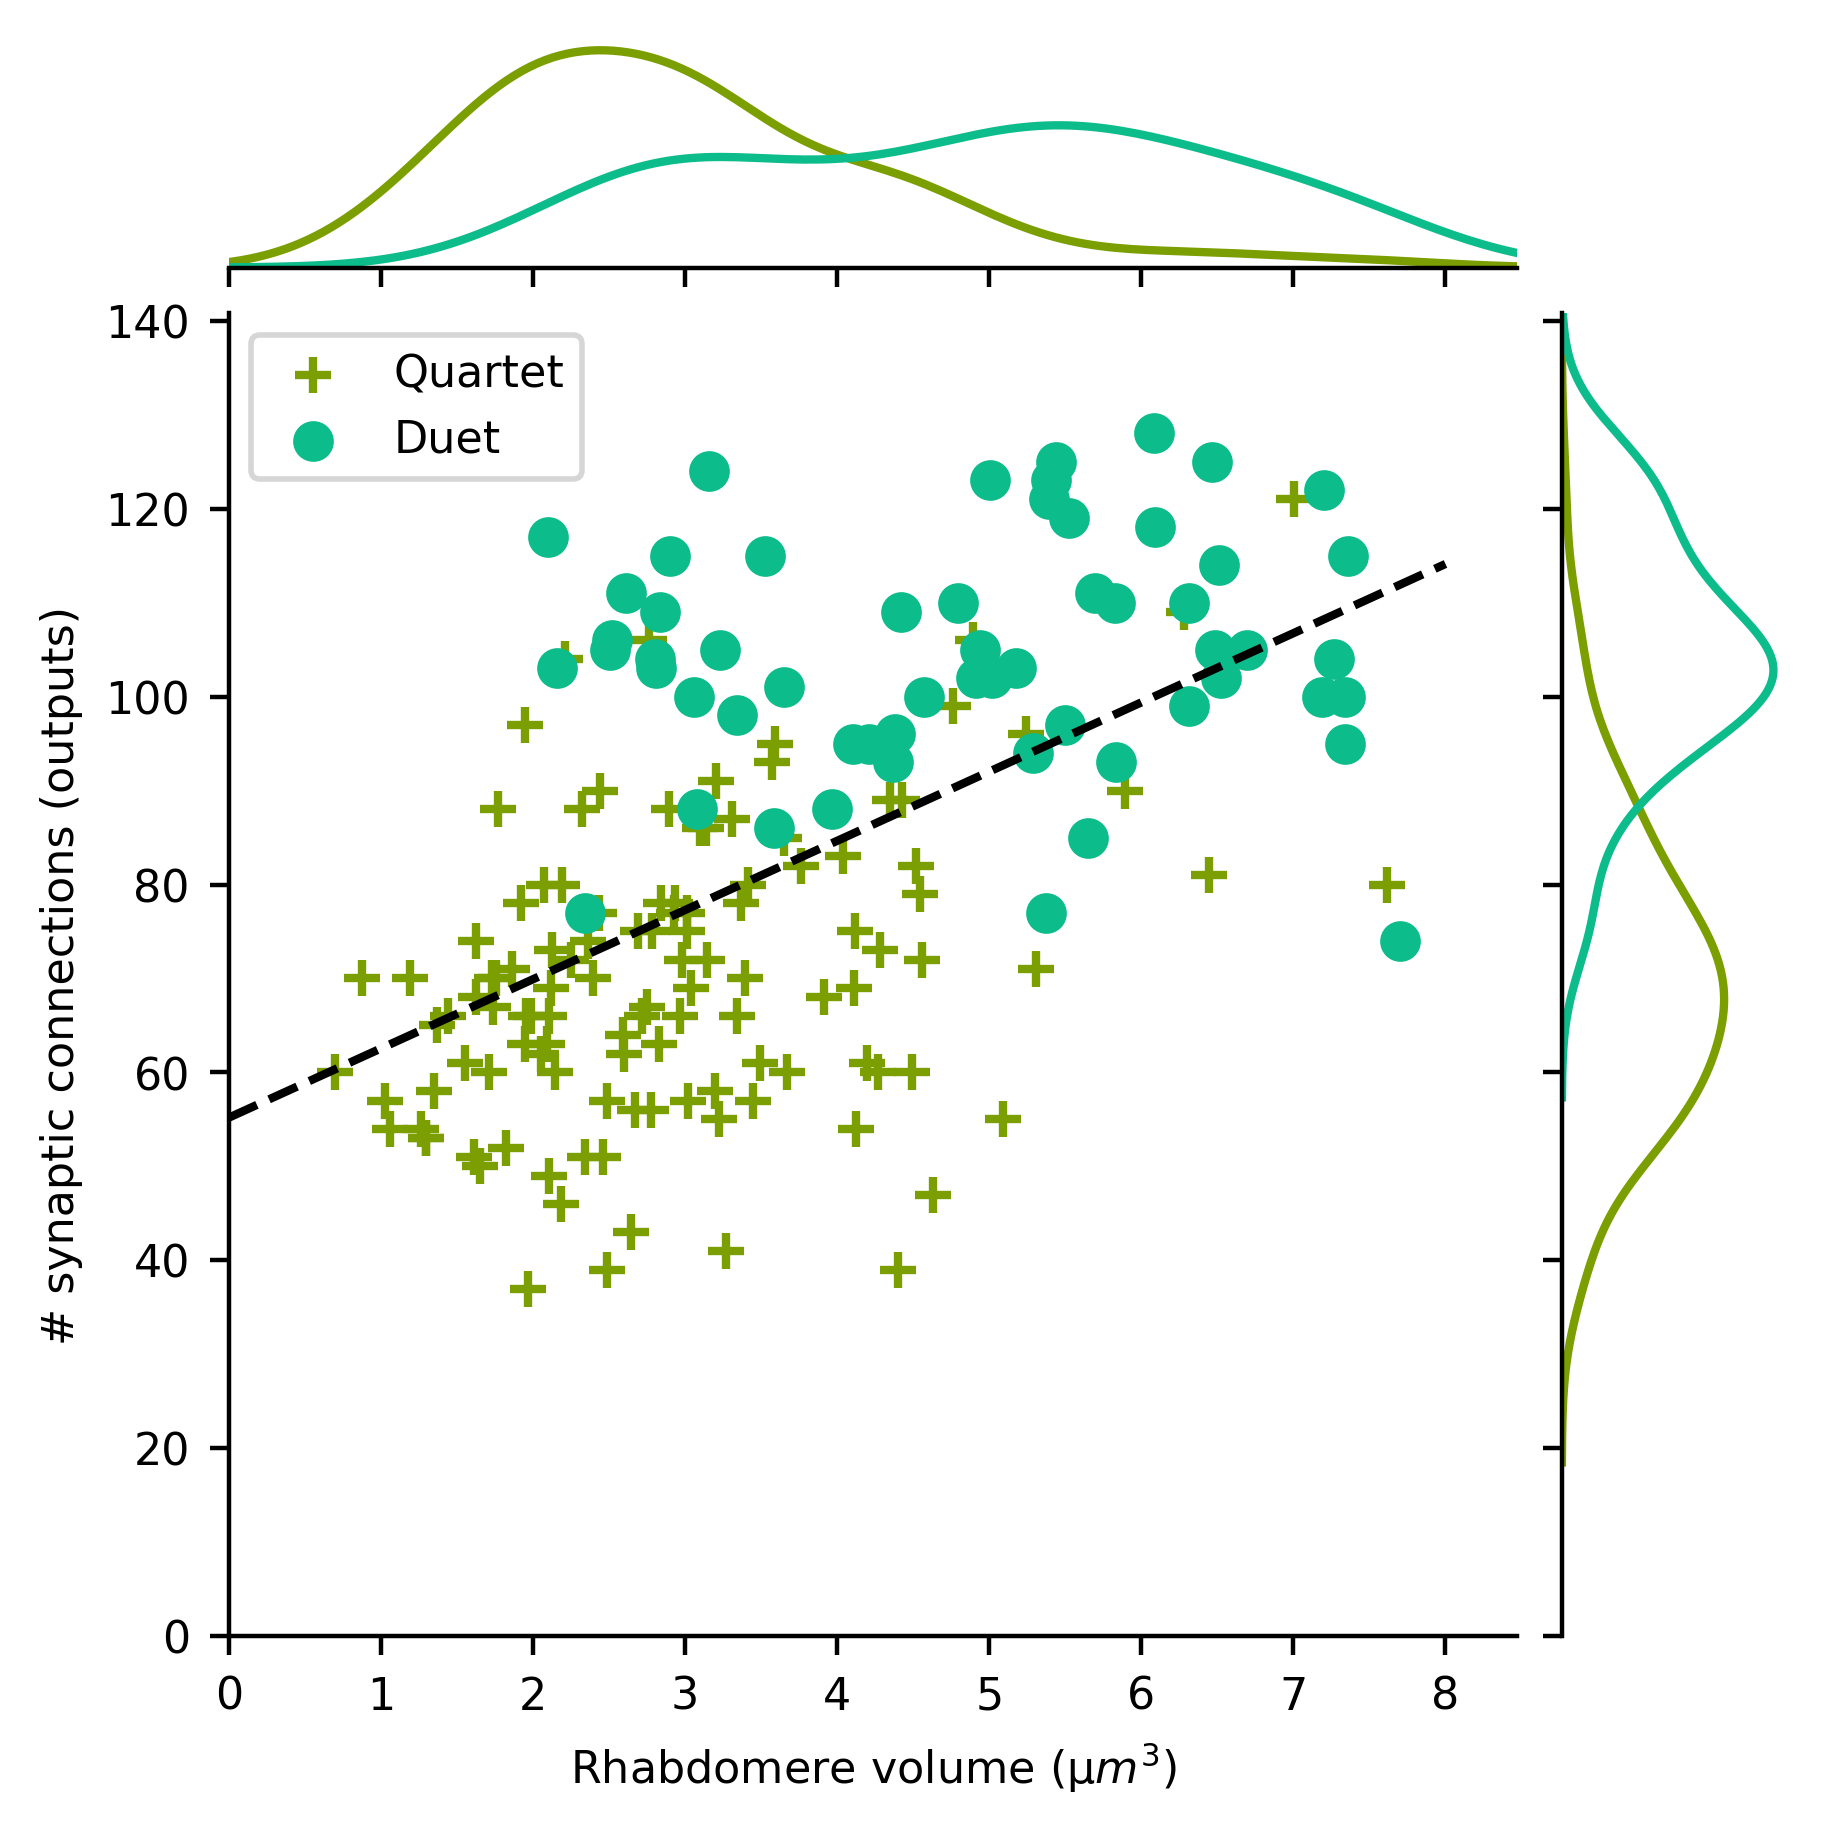

In [25]:
###### VARIABLES TO PLOT AND TEST ######
x_var = 'vol'  
y_var = 'syn_count'  
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]

## OLS ##
_x = data[x_var] 
X = sm.add_constant(_x)
Y = data[y_var]

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

xmax = data[x_var].max()
ymax = data[y_var].max()

g = sns.JointGrid(x=x_var, y=y_var, data=data, height=4.6,
                  xlim=[0, xmax + (xmax*0.1)], ylim=[0, ymax + (ymax*0.1)])

### Aesthetics ###
spr_gname = ['Quartet', 'Duet']
spr_groups = (('R1', 'R4', 'R3', 'R6'), ('R2' , 'R5'))
pt = ('+', 'o')

for i, p in enumerate(spr_groups):
    r_ind = [i for i, s in data['subtype'].iteritems() if s in p]
    rows = data.loc[r_ind]
    
    c = cm[f'R_{spr_gname[i].lower()}']
    
    g.ax_joint.scatter(x=data.loc[r_ind, x_var], y=data.loc[r_ind, y_var], 
                       label=spr_gname[i], marker=pt[i], color=c, s=40)
    g.ax_joint.legend(loc='upper left')
    
    sns.kdeplot(data.loc[r_ind, x_var], legend=False, ax=g.ax_marg_x, color=c)
    sns.kdeplot(data.loc[r_ind, y_var], legend=False, ax=g.ax_marg_y, vertical=True, color=c)

if x_var == 'fvol':
    g.ax_joint.set_xlabel("Fraction of total rhabdom volume")
else:
    g.ax_joint.set_xlabel('Rhabdomere volume (\u03BC$m^3$)')
        
if y_var == 'syn_count':
    g.ax_joint.set_ylabel("# synaptic connections (outputs)")
else:
    g.ax_joint.set_ylabel('# presynaptic terminals')

display(params)
xx = np.arange(0.0, max(_x) + 1.0)
g.ax_joint.plot(xx, params['const'] + params[x_var] * xx, c='k', ls='--')

if save_figs:
    g.savefig(fig_path + f"pr-{x_var}-{y_var}.svg")
    g.savefig(fig_path + f"pr-{x_var}-{y_var}.png")

## Significance tests between duet and quartet photoreceptors

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              syn_count   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     67.00
Date:                Thu, 25 Nov 2021   Prob (F-statistic):           5.84e-14
Time:                        14:05:33   Log-Likelihood:                -755.25
No. Observations:                 174   AIC:                             1514.
Df Residuals:                     172   BIC:                             1521.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.4702      4.411     10.761      0.000      38.763      56.177
fvol         379.6862     46.386      8.185      0.000     288.127     471.245
==============================================================================
Omnibus:                        1.067   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.586   Jarque-Bera (JB):                1.046
Skew:                           0.043   Prob(JB):                        0.593
Kurtosis:                       2.630   Cond. No.                         33.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/nchua/miniconda3/envs/wasp/lib/python3.8/site-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/Users/nchua/miniconda3/envs/wasp/lib/python3.8/site-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


const     47.470244
fvol     379.686154
dtype: float64

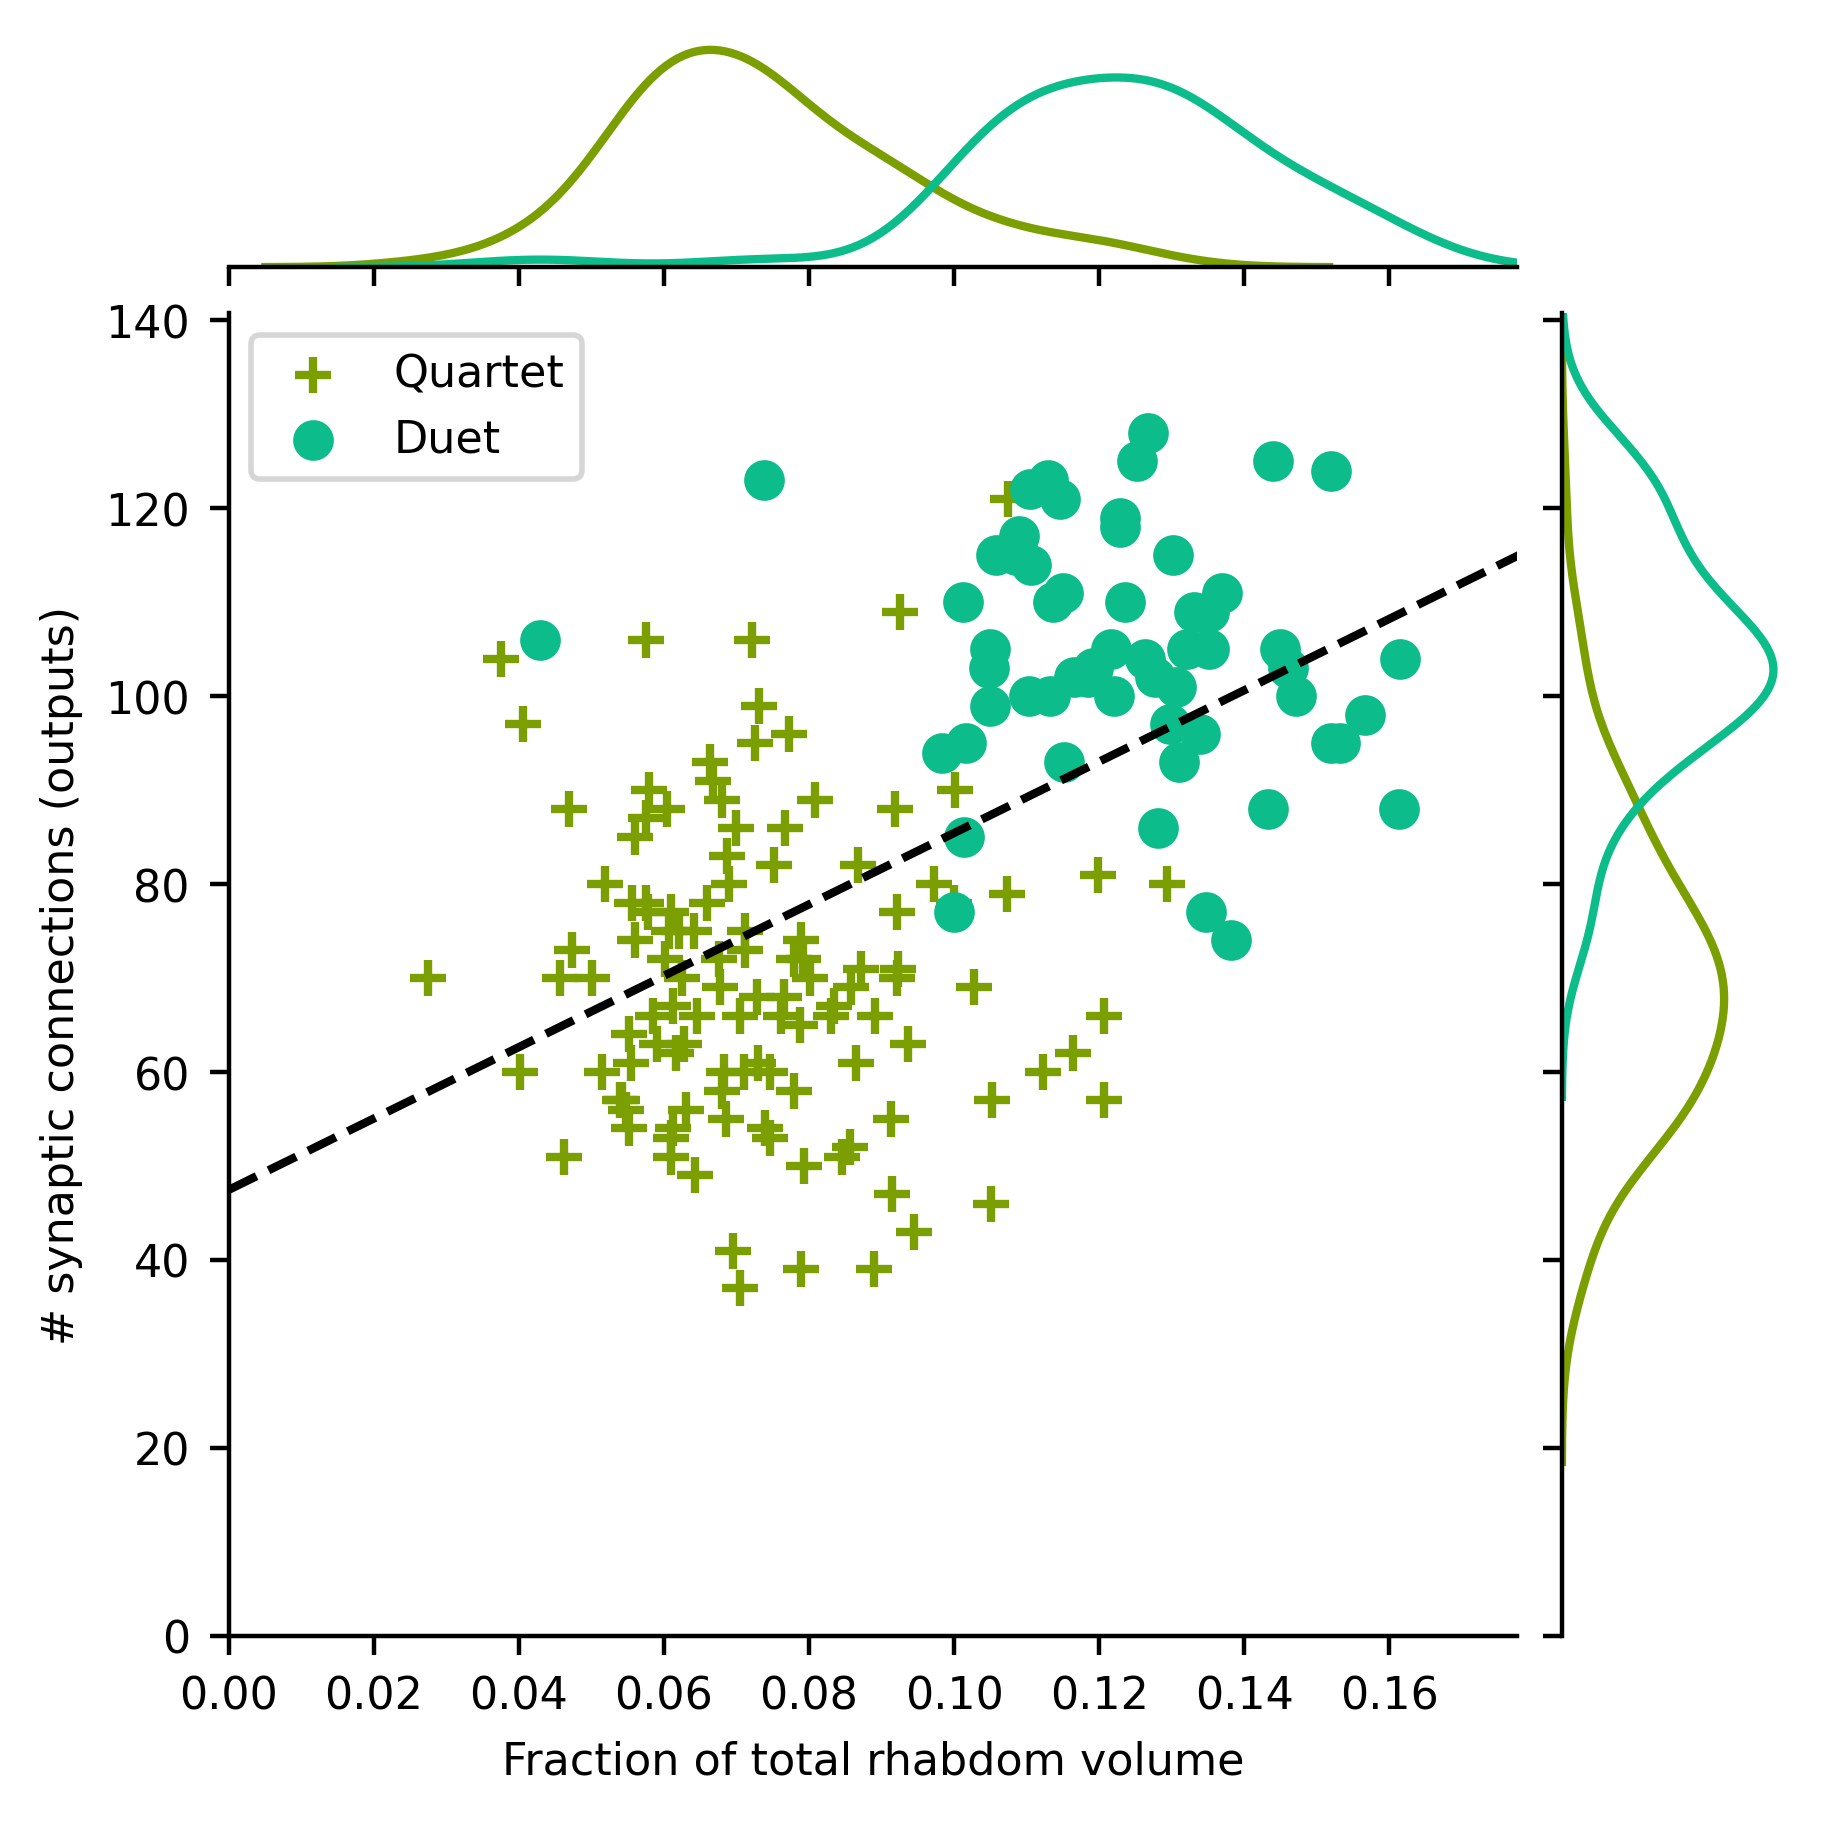

In [26]:
###### VARIABLES TO PLOT AND TEST ######
###### VARIABLES TO PLOT AND TEST ######
x_var = 'fvol'  
y_var = 'syn_count'  
data = combined.loc[[i for i, row in combined.iterrows() if row['subtype'] not in ['R7', 'R7p', 'R8']]]

## OLS ##
_x = data[x_var] 
X = sm.add_constant(_x)
Y = data[y_var]

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())

xmax = data[x_var].max()
ymax = data[y_var].max()

g = sns.JointGrid(x=x_var, y=y_var, data=data, height=4.6,
                  xlim=[0, xmax + (xmax*0.1)], ylim=[0, ymax + (ymax*0.1)])

### Aesthetics ###
spr_gname = ['Quartet', 'Duet']
spr_groups = (('R1', 'R4', 'R3', 'R6'), ('R2' , 'R5'))
pt = ('+', 'o')

for i, p in enumerate(spr_groups):
    r_ind = [i for i, s in data['subtype'].iteritems() if s in p]
    rows = data.loc[r_ind]
    
    c = cm[f'R_{spr_gname[i].lower()}']
    
    g.ax_joint.scatter(x=data.loc[r_ind, x_var], y=data.loc[r_ind, y_var], 
                       label=spr_gname[i], marker=pt[i], color=c, s=40)
    g.ax_joint.legend(loc='upper left')
    
    sns.kdeplot(data.loc[r_ind, x_var], legend=False, ax=g.ax_marg_x, color=c)
    sns.kdeplot(data.loc[r_ind, y_var], legend=False, ax=g.ax_marg_y, vertical=True, color=c)

if x_var == 'fvol':
    g.ax_joint.set_xlabel("Fraction of total rhabdom volume")
else:
    g.ax_joint.set_xlabel('Rhabdomere volume (\u03BC$m^3$)')
        
if y_var == 'syn_count':
    g.ax_joint.set_ylabel("# synaptic connections (outputs)")
else:
    g.ax_joint.set_ylabel('# presynaptic terminals')

display(params)
xx = np.arange(0.0, max(_x) + 1.0)
g.ax_joint.plot(xx, params['const'] + params[x_var] * xx, c='k', ls='--')

if save_figs:
    g.savefig(fig_path + f"pr-{x_var}-{y_var}.svg")
    g.savefig(fig_path + f"pr-{x_var}-{y_var}.png")